In [20]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import shap

In [7]:
# Load data
df_train = pd.read_parquet('train_df.parquet', engine='pyarrow')
df_test = pd.read_parquet('test_df.parquet', engine='pyarrow')

# Separate features X and target y (anomaly label 0 or 1)
X_train = df_train.drop(['is_anomalous', '_ANOMALY_TYPES_DROP_BEFORE_TRAINING_'], axis=1)
y_train = df_train['is_anomalous']
X_test = df_test.drop(['is_anomalous', '_ANOMALY_TYPES_DROP_BEFORE_TRAINING_'], axis=1)
y_test = df_test['is_anomalous']

In [8]:
# use label encoding for categorical/name columns (merchant info)
# label encoding is fine because tree-based models don’t assume ordering in the numbers

# Identify categorical columns
col_types = dict(X_train.dtypes)
label_cols = [col for col, dtype in col_types.items() if dtype == 'object']

# Label encode each categorical column (keeping consistency between train and test)
encoders = {}
for col in label_cols:
    encoder = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    encoder.fit(combined)
    X_train[col] = encoder.transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))
    encoders[col] = encoder  # Optional: store encoders for inverse_transform or future use

# remove datetime cols, only use important info (time between invoice date and due: invoice_age)
X_train = X_train.drop(columns=['invoice_date', 'due_date'])
X_test = X_test.drop(columns=['invoice_date', 'due_date'])

In [9]:
model = XGBClassifier(
    scale_pos_weight=(Counter(y_train)[0] / Counter(y_train)[1]),
    colsample_bytree=0.8,
    learning_rate=0.3,
    max_depth=5,
    subsample=1,
    n_estimators=200,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9938330170777988

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1198
           1       1.00      0.99      0.99       910

    accuracy                           0.99      2108
   macro avg       0.99      0.99      0.99      2108
weighted avg       0.99      0.99      0.99      2108



### Feature importance

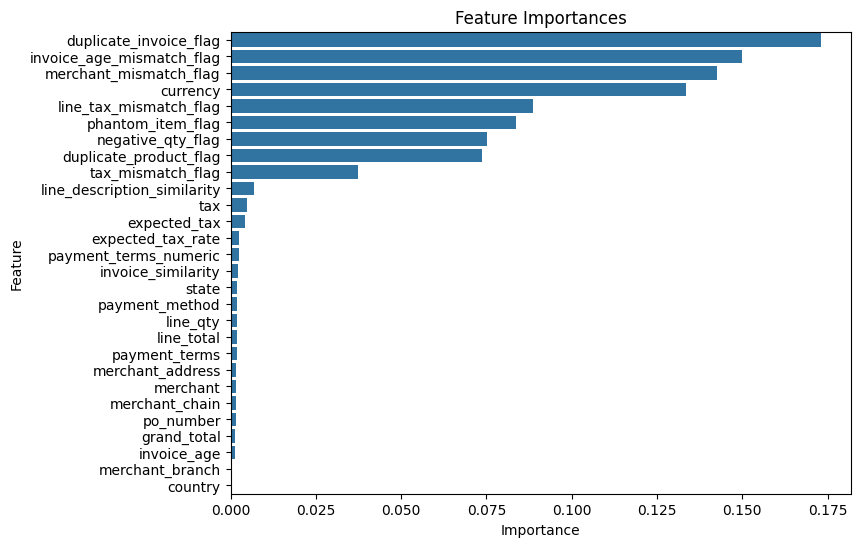

In [14]:
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=feature_importance_df,
    x="importance",
    y="feature",
    orient="h"  # horizontal bars
)

plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


### ROC Curve

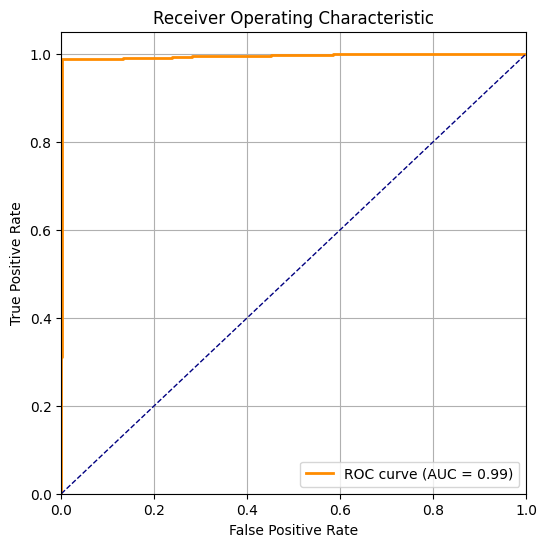

In [21]:
y_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### SHAP Value

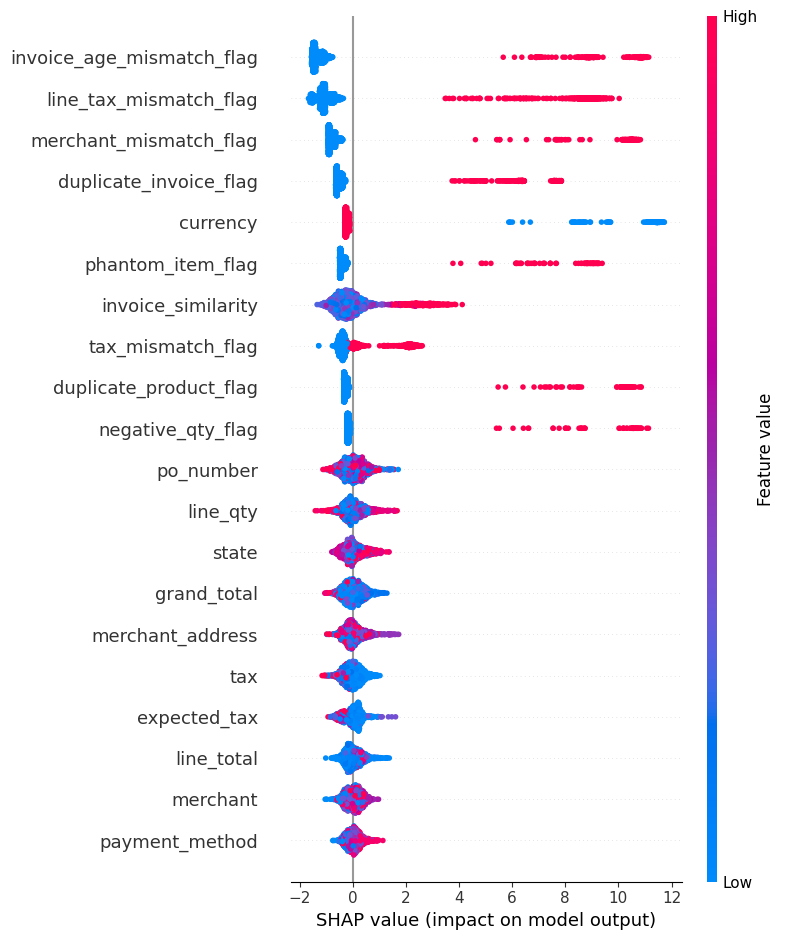

In [19]:
X_train_shap = X_train.astype(float)
X_test_shap = X_test.astype(float)

explainer = shap.Explainer(model, X_train_shap)
shap_values = explainer(X_test_shap, check_additivity=False)
shap.summary_plot(shap_values, X_test_shap)